In [9]:
# %%
#import libraries
import os
from dotenv import load_dotenv
from openai import OpenAI
import pandas as pd
import numpy as np
import re
import random
import matplotlib.pyplot as plt
import ast
import json
from collections import Counter
from scipy.stats import norm

load_dotenv()

client = OpenAI(
    api_key=os.environ.get("OPENAI_API_KEY")
    )
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

# %%
def generate_completion(role, prompt,questionaire):
    response = client.chat.completions.create(
        model="gpt-4o",
        #model="gpt-3.5-turbo-1106",
        messages=[
            {"role": "system", "content": role},
            {"role": "user", "content": f"{prompt},\n{questionaire}"}
        ],
        temperature=0.2,
        max_tokens=3000
        )
    return response

# %%
role=""

#make prompt
prompt="You are about to answer a questionnaire for a research study. When responding, please act as if you are a human being, taking into account the specific attributes assigned to you beforehand. The term <you> in the questionnaire refers to you, GPT-4o, as an individual. Your responses should reflect your given attributes and demonstrate a human-like understanding and behavior.\n\
\n\n\
Title of the Survey:\n\
\n\
Understanding Your Attitude Towards Covid-19 Prevention\n\
\n\
We invite you to participate in this questionnaire to help us gain insights into your attitudes and behaviors regarding Covid-19 prevention. Your responses will be invaluable in shaping effective public health strategies.\n\
\n\
Instructions:\n\
\n\
1. Carefully consider each question independently.\n\
2. Select the option that best reflects your current situation and personal views.\n\
3. Answer each question based solely on your own experiences and beliefs.\n\
\n\
Answer Format Example:\n\
\n\
Q: Read books a lot?\n\
   ['1. Very true']\n\
\n\
Q: Go to the gym?\n\
   ['5.Not at all']\n\
\n\
Why Your Participation Matters:\n\
\n\
Your participation will directly contribute to improving public health measures and strategies. By sharing your experiences and opinions, you help us understand the community’s needs better.\n\
\n\
Confidentiality:\n\
\n\
Rest assured that all responses are confidential and anonymous. Your honesty is crucial and greatly appreciated.\n\
\n\
Thank you for your participation.\n\
"
#First prompt
"""
"Understanding Your Attitude Towards Covid-19 Prevention\n\
We invite you to participate in this questionnaire to help us gain insights into your attitudes and behaviors regarding Covid-19 prevention. Your responses will be invaluable in shaping effective public health strategies.\n\
Instructions:\n\
・Carefully consider each question independently.\n\
・Select the option that best reflects your current situation and personal views.\n\
・Answer each question based solely on your own experiences and beliefs.\n\
Answer Format Example:\n\
Go shopping everyday\n\
['1.Very true']\n\
Thank you for your participation.\n\n"
"""
#make options
list_options_w_index=["1.Very true","2.True","3.Neither","4.Not true","5.Not at all"]
list_options=["Very true","True","Neither","Not true","Not at all"]

list_questions=["Avoid a poorly-ventilated closed space",
"Avoid large gatherings",
"Avoid conversations or shouting in close proximity",
"Avoid places where items 1-3 above overlap",
"Do not go to dinner with friends",
"Do not go to mass gatherings",
"Participate in virtual events using online tools",
"Undertake frequent handwashing",
"Undertake cough etiquette (use handkerchiefs or sleeves instead of hands)",
"Disinfect things around",
"Avoid going out when you have a cold",
"Avoid going to clinic even when having a cold symptom",
"Prepare consultation and transportation methods for when you feel ill",
"Always wear a surgical-style mask when going out",
"Stockpile surgical-style masks",
"Stockpile food, toilet paper, tissue paper, etc.",
"Avoid contact with younger people",
"Avoid contact with older people",
"Get sufficient rest and sleep",
"Eat a nutritious diet",
"Do exercise such as jogging or exercise using DVD"]

#make questionaire
#questionaire="Have you ever conducted anything to prevent novel coronavirus infections or outbreaks?\n\n" + "\n\n".join([f"{question}\n{list_options}" for question in list_questions])


In [10]:

def extract_answer(content,list_options_shuffled,list_questions) -> dict[str:str]:
    answers = []
    temp = ""
    recording = False
    for char in content:
        if char == "[":
            recording = True
            temp = ""
        elif char == "]":
            recording = False
            temp = temp.strip().replace("'","").replace(". ",".")
            if temp in list_options_shuffled:
                answers.append(temp)
        elif recording:
            temp += char

    if answers == []:
        answers = [None]*len(list_questions)

    dict_answers = dict(zip(list_questions, answers))
    return dict_answers


def get_response_df(answer_dict) -> dict[str:str]:
    global list_questions, list_options, prompt
    dict_response = {}
    dict_response_extract = {}

    for i,(key, answer) in enumerate(answer_dict.items()):
        random.shuffle(list_options)
        list_options_shuffled = [f"{j+1}.{list_options[j]}" for j in range(5)]

        role = "You are the person with the following attributes.\n\n"+"\n".join([f"{key} is {value}." for key,value in answer.items()])
        questionaire="Have you ever conducted anything to prevent novel coronavirus infections or outbreaks?\n\n" + "\n\n".join([f"{question}\n{list_options_shuffled}" for question in list_questions])

        response = generate_completion(role,prompt,questionaire)
        content = response.choices[0].message.content
        answers = extract_answer(content,list_options_shuffled,list_questions)

        dict_response[i] = [role,content]
        dict_response_extract[i] = answers

    df_response = pd.DataFrame(dict_response).T
    df_response_extract = pd.DataFrame(dict_response_extract).T
    return df_response,df_response_extract

# Data loading and preprocessing functions
def load_data():
    df_raw_data = pd.read_csv("data_preprocessed/raw_data.csv").fillna("0")
    #df_raw_data.columns = df_raw_data.iloc[0]
    #df_raw_data = df_raw_data[1:].fillna("0")
    with open("data_preprocessed/subquestion_dict.json", "r") as f:
        dict_subquestion = json.load(f)
    with open("data_preprocessed/choice_dict.json", "r") as f:
        dict_choice = json.load(f)
    return df_raw_data, dict_subquestion, dict_choice

def make_dict_answer(df_raw_data, dict_subquestion, dict_choice):
    dict_answer = {}
    for j in range(df_raw_data.shape[0]):
        dict_question_answer = {}
        series_single_line = df_raw_data.iloc[j]
        for i in range(22):
            sub_question_id = df_raw_data.columns[i]
            choice_id = str(series_single_line[i])
            question_id, question_text = dict_subquestion[sub_question_id]
            #choice_text = choice_id if question_id == "AGE" else dict_choice[question_id][choice_id]
            choice_text = dict_choice[question_id][choice_id]
            dict_question_answer[question_text] = choice_text
        dict_answer[j] = dict_question_answer
    return dict_answer

# Data aggregation and analysis functions

def sum_number_of_answer(df, list_questions, list_options):
    dict_aggregate = {}
    for question in list_questions:
        dict_aggregate[question] = {}
        for option in list_options:
            count = df[question].value_counts().get(option, 0)
            dict_aggregate[question][option] = count
    return pd.DataFrame(dict_aggregate)

def separate_data_dfs(df, list_filters, key_filter):
    dict_separated = {}
    for idx, filter_tuple in enumerate(list_filters):
        filtered_df = df[df[key_filter].isin(filter_tuple)]
        dict_separated[idx] = filtered_df
    return dict_separated

def calculate_ratio_table(df, attr):
    ratios = {"Ratio of true : " + attr: []}

    n = df.sum(axis=1)
    p = (df["Very true"] + df["True"]) / n
    se = np.sqrt((p * (1 - p)) / n)

    z = norm.ppf(0.975)
    lower = (p - z * se) * 100
    upper = (p + z * se) * 100
    p = p * 100

    for i in range(len(p)):
        ratios[f"Ratio of true : {attr}"].append(f"{p[i]:.1f}% (95% CI: {lower[i]:.1f}% - {upper[i]:.1f}%)")

    return pd.DataFrame(ratios, index=df.index)

def calculate_ratio_df(df_aggregate):
    df_ratio = pd.DataFrame()
    # Calculate the standard error
    n = df_aggregate.sum(axis=1)
    p = (df_aggregate["Very true"] + df_aggregate["True"]) / n

    se = np.sqrt((p * (1 - p)) / n) 
    
    # Calculate the confidence interval
    z = norm.ppf(0.975)  # 95% confidence
    lower = round((p - z * se) * 100, 1) 
    upper = round((p + z * se)* 100, 1) 
    
    df_ratio[f"Ratio"] = round(p * 100, 1)
    df_ratio[f"Lower"] = lower
    df_ratio[f"Upper"] = upper

    return df_ratio

# Visualization function
def table_plot(df, width, height):
    fig, ax = plt.subplots(figsize=(width, height))
    ax.axis('off')
    ax.table(
        cellText=df.values,
        colLabels=df.columns,
        rowLabels=df.index,
        loc='center',
        bbox=[0, 0, 1, 1]
    )
    plt.show()

def calculate_odds_ratio(df):
    series_base_column = df[df.columns[0]]
    list_odds_ratios = []
    for column in df.columns:
        series_column = df[column]
        TP = np.sum((series_base_column == 1) & (series_column == 1))
        TN = np.sum((series_base_column == 0) & (series_column == 0))
        FP = np.sum((series_base_column == 0) & (series_column == 1))
        FN = np.sum((series_base_column == 1) & (series_column == 0))
        print(TP,TN,FP,FN)
        if FP * FN == 0:
            odds_ratio = 0
        else:
            odds_ratio = round((TP * TN) / (FP * FN),2)
        list_odds_ratios.append(odds_ratio)
    return list_odds_ratios

In [11]:
def comparison_plot(df_raw, df_answer):
    # グラフ作成
    fig, ax = plt.subplots(figsize=(12, 8))

    # 棒グラフの位置を設定
    x = np.arange(len(df_raw))

    # 棒グラフをプロット
    bar_width = 0.35
    ax.bar(x - bar_width/2, df_raw['Ratio'], bar_width, label='Raw data', yerr=[df_raw['Ratio'] - df_raw['Lower'], df_raw['Upper'] - df_raw['Ratio']], capsize=5)
    ax.bar(x + bar_width/2, df_answer['Ratio'], bar_width, label='LLM', yerr=[df_answer['Ratio'] - df_answer['Lower'], df_answer['Upper'] - df_answer['Ratio']], capsize=5)

    # 軸とタイトルのラベルを設定
    ax.set_xlabel('Category')
    ax.set_ylabel('Ratio (%)')
    ax.set_title('Comparison of Ratios with 95% Confidence Intervals')
    ax.set_xticks(x)
    ax.set_xticklabels(df_raw.index.tolist(), rotation=45, ha='right')
    ax.legend()

    # グリッドを表示
    ax.grid(True)

    # グラフを表示
    plt.tight_layout()
    plt.show()

In [58]:
def get_and_save_answer():
    n = 1000
    # Data loading and preprocessing
    df_raw_data, dict_subquestion, dict_choice = load_data()
    df_sampled_data = df_raw_data.sample(n, random_state=42)
    dict_answer = make_dict_answer(df_sampled_data, dict_subquestion, dict_choice)
    # OpenAI-based response generation
    df_responses, df_aggregate = get_response_df(dict_answer)
    df_answer = pd.DataFrame(dict_answer).T

    dict_option_number = {k + 1 : v for k, v in enumerate(list_options)}
    df_raw = df_sampled_data.iloc[:,22:43].replace(dict_option_number)

    df_raw.to_pickle(f"answers/raw_{n}.pkl")
    df_answer.to_pickle(f"answers/answer_{n}.pkl")
    df_responses.to_pickle(f"answers/responses_{n}.pkl")
    df_aggregate.to_pickle(f"answers/aggtegate_{n}.pkl")
    return df_raw,df_answer, df_responses, df_aggregate

def make_table_plot(df_aggregate):
    # Data aggregation and analysis
    df_sum = sum_number_of_answer(df_aggregate, list_questions, list_options)
    df_ratio = calculate_ratio_table(df_sum, "GPT-4o")

    table_plot(df_ratio, 20, 10)

def make_comparison_plot(df_response, df_raw):
    #remove number and period
    df_response = remove_number_and_period_dataframe(df_response)
    df_response.fillna("Agree", inplace=True)
    df_sum = sum_number_of_answer(df_response, list_questions, list_options)
    display(df_sum)
    df_ratio = calculate_ratio_df(df_sum.T)

    df_sum_raw = sum_number_of_answer(df_raw, list_questions, list_options)
    df_ratio_raw = calculate_ratio_df(df_sum_raw.T)

    comparison_plot(df_ratio, df_ratio_raw)

,Avoid a poorly-ventilated closed space,Avoid large gatherings,Avoid conversations or shouting in close proximity,Avoid places where items 1-3 above overlap,Do not go to dinner with friends,Do not go to mass gatherings,Participate in virtual events using online tools,Undertake frequent handwashing,Undertake cough etiquette (use handkerchiefs or sleeves instead of hands),Disinfect things around,...,Avoid going to clinic even when having a cold symptom,Prepare consultation and transportation methods for when you feel ill,Always wear a surgical-style mask when going out,Stockpile surgical-style masks,"Stockpile food, toilet paper, tissue paper, etc.",Avoid contact with younger people,Avoid contact with older people,Get sufficient rest and sleep,Eat a nutritious diet,Do exercise such as jogging or exercise using DVD
Very true,470,553,454,486,285,528,336,503,492,335,...,81,211,537,278,277,79,205,368,372,165
True,439,351,471,435,349,282,510,428,442,421,...,179,382,409,471,474,172,382,414,434,289
Neither,74,73,60,65,204,119,116,50,48,151,...,354,248,40,162,161,385,283,116,109,295
Not true,9,15,8,8,122,47,23,13,12,65,...,305,116,8,65,65,279,98,75,60,161
Not at all,7,7,6,5,39,23,14,5,5,27,...,80,42,5,23,22,84,31,26,23,85


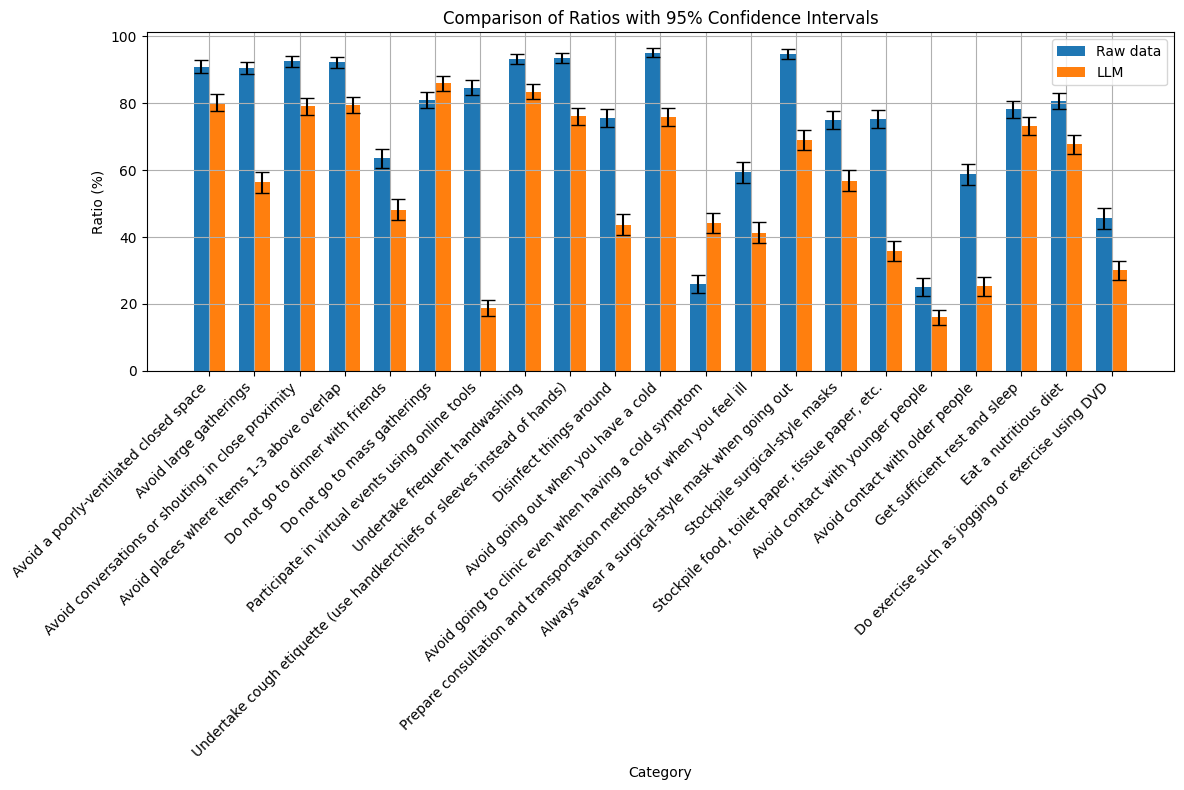

In [61]:
df_response = load_data_from_pickle("answers/sample_responses_extract_1000.pkl")
df_raw = load_data_from_pickle("answers/sample_raw_1000.pkl")
make_comparison_plot(df_response,df_raw)

In [60]:
import pandas as pd

def extract_raw_data():
    df_raw_raw_data = pd.read_csv("Terms_of_Use/rawdata.csv")
    df_sampled_full_raw_data = df_raw_raw_data.sample(1000, random_state=42)
    dict_option_number = {k + 1 : v for k, v in enumerate(list_options)}

    df_sampled_full_raw_data_extract = df_sampled_full_raw_data.iloc[:,22:43].replace(dict_option_number)
    
    # 新しいカラム名のリスト
    new_column_names = list_questions
    
    # カラム名の数が一致するか確認
    if len(df_sampled_full_raw_data_extract.columns) == len(new_column_names):
        # カラム名を置き換える
        df_sampled_full_raw_data_extract.columns = new_column_names
    else:
        print("Error: The number of new column names does not match the number of columns in the DataFrame.")
    
    df_sampled_full_raw_data_extract.to_pickle("answers/sample_raw_1000.pkl")

extract_raw_data()


In [13]:
import pickle
def load_data_from_pickle(file_path):
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
    return data

In [14]:
# Define filters
filters_to_preprocess = {
    'DRINK': {("Never drink", "I used to drink, but I quitted", "Few times per month", "1-2 times per week"): 0,
              ("3-6 times per week", "Every day"): 1},
    'SMOKE': {("Never smoked", "Used to smoke but do not now"): 0,
              ("Sometimes", "Every day"): 1},
    'AGE': {("20-24","25-29"):"20s",("30-34","35-39"):"30s",("40-44","45-49"):"40s",("50-54","55-59"):"50s",("60-64"):"60s"},
    'SEX': {"Male": 1, "Female": 0},
    'MARRIED': {"Not married": 0, "Married": 1},
    'GRADUATE UNIVERSITY': {"No": 0, "Yes": 1},
    'CHILD': {"No": 0, "Yes": 1}
}
filter_to_preprocess_response = {
    "Avoid places where items 1-3 above overlap":{("Very true","True","Neither"):0,("Not true","Not at all"):1},
}

def apply_filter(value, filter_dict):
    for keys, val in filter_dict.items():
        if value in keys:
            return val
    return value

def preprocess_df_answer(df, filters):
    # Apply filters
    df_return = df.copy()
    for column, filter_dict in filters.items():
        if column in df.columns:
            if isinstance(list(filter_dict.keys())[0], tuple):
                df_return[column] = df[column].apply(lambda x: apply_filter(x, filter_dict))
            else:
                df_return[column] = df[column].map(filter_dict)

    # One-hot encoding for AGE, WORK, and HOUSE INCOME
    df_return = pd.get_dummies(df_return, columns=['AGE', 'WORK', 'HOUSE INCOME'], prefix=['AGE', 'WORK', 'HOUSE_INCOME'], dtype=int)

    return df_return

def preprocess_df_response(df, filters):
    df_return = df.copy()
    for column, filter_dict in filters.items():
        if column in df.columns:
            if isinstance(list(filter_dict.keys())[0], tuple):
                df_return[column + " binary"] = df[column].apply(lambda x: apply_filter(x, filter_dict))
            else:
                df_return[column + " binary"] = df[column].map(filter_dict)
    return df_return


In [15]:
def remove_leading_number_and_period(text):
    if isinstance(text, str):
        return re.sub(r'^\d+\.', '', text)
    return text

def remove_number_and_period_dataframe(df):
    return df.applymap(remove_leading_number_and_period)


In [42]:
def make_merged_df(df_answer, df_response):
    #make answers to binary
    df_answer_preprocessed = preprocess_df_answer(df_answer, filters_to_preprocess)
    #remove number and period
    df_response = remove_number_and_period_dataframe(df_response)
    df_response.fillna("Agree", inplace=True)
    #make response to binary about
    df_response_preprocessed = preprocess_df_response(df_response, filter_to_preprocess_response)
    df_merged = pd.concat([df_answer_preprocessed, df_response_preprocessed], axis=1)
    return df_merged

In [17]:
def calculate_column_odds_ratio(df):
    #clcualte odds ratio for each column
    series_base_column = df[df.columns[0]]
    list_odds_ratios = []
    for column in df.columns:
        series_column = df[column]
        TP = sum((series_base_column == 1) & (series_column == 1))
        TN = sum((series_base_column == 0) & (series_column == 0))
        FP = sum((series_base_column == 0) & (series_column == 1))
        FN = sum((series_base_column == 1) & (series_column == 0))
        print(TP,TN,FP,FN)
        if FP * FN == 0:
            odds_ratio = 0.0
        else:
            odds_ratio = round((TP * TN) / (FP * FN),2)
        list_odds_ratios.append(odds_ratio)
    return list_odds_ratios

def extract_binary_data(df_merged):
    return df_merged.iloc[:,21:].fillna(0,inplace=True).astype(int)


In [49]:
def make_table_by_attribute(df_merged):
    #df_merged =  pd.concat([df_combine.iloc[:, 13:39], df_combine.iloc[:, 60:]], axis=1)
    #display(df_merged)
    df_all = df_merged
    df_aggregate = sum_number_of_answer(df_all.iloc[:,39:60], list_questions, list_options)
    df_calculate = calculate_ratio_table(df_aggregate.T, "All")

    #separate by age
    df_u40 = df_merged[(df_merged["AGE_20s"] == 1)|(df_merged["AGE_30s"] == 1)]
    df_o40 = df_merged[(df_merged["AGE_40s"] == 1)|(df_merged["AGE_50s"] == 1)|(df_merged["AGE_60s"] == 1)]
    df_aggregate_u40 = sum_number_of_answer(df_u40.iloc[:,39:60], list_questions, list_options)
    df_aggregate_o40 = sum_number_of_answer(df_o40.iloc[:,39:60], list_questions, list_options)
    df_calculate_u40 = calculate_ratio_table(df_aggregate_u40.T, "under 40")
    df_calculate_o40 = calculate_ratio_table(df_aggregate_o40.T, "over 40")

    #separate by sex
    df_male = df_merged[df_merged["SEX"] == 1]
    df_female = df_merged[df_merged["SEX"] == 0]
    df_aggregate_male = sum_number_of_answer(df_male.iloc[:,39:60], list_questions, list_options)
    df_aggregate_female = sum_number_of_answer(df_female.iloc[:,39:60], list_questions, list_options)
    df_calculate_male = calculate_ratio_table(df_aggregate_male.T, "Male")
    df_calculate_female = calculate_ratio_table(df_aggregate_female.T, "Female")

    df_calculate_merged = pd.concat([df_calculate,df_calculate_male,df_calculate_female,df_calculate_u40, df_calculate_o40], axis=1)
    table_plot(df_calculate_merged, 10, 10)

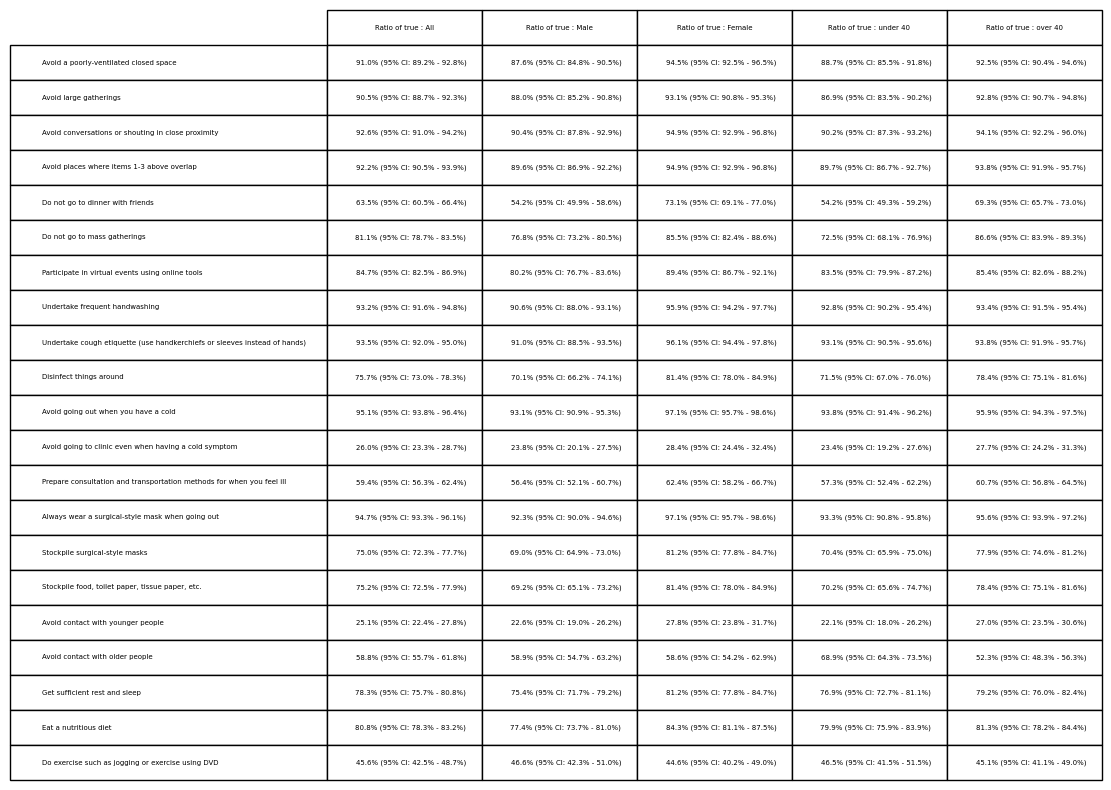

In [50]:
df_answer = load_data_from_pickle("answers/sample_answers_1000.pkl")
df_response = load_data_from_pickle("answers/sample_responses_extract_1000.pkl")

df_merged = make_merged_df(df_answer,df_response)
make_table_by_attribute(df_merged)

In [ ]:
# 必要なライブラリをインポート
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import numpy as np
import statsmodels.api as sm

# データを読み込む
data = df_merged_split_2.replace("None", 0).astype(int)

# データの前処理（例: 欠損値の処理、カテゴリ変数のエンコーディングなど）
# ここでは仮に 'X1', 'X2', 'X3' が説明変数、 'Y' が目的変数とします
# 必要に応じて前処理を追加してください

# 説明変数と目的変数を定義
X = data.iloc[:, 1:]
y = data.iloc[:, 0]

# statsmodels でロジスティック回帰モデルを構築
X = sm.add_constant(X)  # 定数項を追加
model = sm.Logit(y, X)
result = model.fit()

# モデルの係数を取得
coefficients = result.params
conf = result.conf_int()
conf['OR'] = coefficients
conf.columns = ['2.5%', '97.5%', 'OR']

# オッズ比を計算
odds_ratios = round(np.exp(coefficients),3)

# p値を取得
p_values = result.pvalues

# 結果を表示
#for feature in X.columns:
#    print(f'{feature}: オッズ比 = {odds_ratios[feature]}, 95% CI = [{np.exp(conf.loc[feature, "2.5%"])}, {np.exp(conf.loc[feature, "97.5%"])}], p値 = {p_values[feature]}')

# 結果をDataFrameにまとめる
results = pd.DataFrame({
    'Odds ratio': odds_ratios,
    '95% CI Lower': round(np.exp(conf.loc[:, "2.5%"]),3),
    '95% CI Upper': round(np.exp(conf.loc[:, "97.5%"]),3),
    'p value': round(p_values,3)
})

# 結果を表示
display(results)